In [17]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle
from MoDE import MoDE
from sklearn.manifold import TSNE, Isomap, MDS
from metrics import distance_metric, correlation_metric, order_preservation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
data = loadmat("data/big_stock.mat")["StockData"]
score = loadmat("data/big_stock.mat")["Score"]

In [19]:
#normalize
m = np.mean(data, axis=1)
data = data - m.reshape((-1,1))

s = np.max(data, axis=1) - np.min(data, axis=1)
data = data / s.reshape((-1,1))

In [20]:
data.shape

(2252, 1024)

In [21]:
# for now using exact distance matrix
from sklearn.metrics import pairwise_distances
dm = pairwise_distances(data, n_jobs=-1)

In [22]:
# temporary: for now limit the decimals
dm = np.round(dm, decimals=5)

In [23]:
mode = MoDE(n_neighbor=20, max_iter=100000, tol=0.0001, verbose=True)

In [24]:
start = time.time()

x_2d_mode = mode.fit_transform(data, score.squeeze(), dm, dm)

print("time: ", time.time() - start)

0.0045871559633027525
Start of Gradient Descent algorithm
0 out of 100000 iterations has passed
10000 out of 100000 iterations has passed
20000 out of 100000 iterations has passed
30000 out of 100000 iterations has passed
40000 out of 100000 iterations has passed
50000 out of 100000 iterations has passed
60000 out of 100000 iterations has passed
70000 out of 100000 iterations has passed
80000 out of 100000 iterations has passed
90000 out of 100000 iterations has passed
end of GD algorithm
time:  241.63694977760315


In [25]:
# mds
mds = MDS()
x_2d_mds = mds.fit_transform(data)

In [26]:
# ISOMAP
isomap = Isomap(n_neighbors=20, n_components=2)
x_2d_isomap = isomap.fit_transform(data)

In [27]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=6.5, n_iter=3000, verbose=1)
x_2d_tsne = tsne.fit_transform(data)

[t-SNE] Computing 20 nearest neighbors...
[t-SNE] Indexed 2252 samples in 0.183s...
[t-SNE] Computed neighbors for 2252 samples in 5.878s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2252
[t-SNE] Computed conditional probabilities for sample 2000 / 2252
[t-SNE] Computed conditional probabilities for sample 2252 / 2252
[t-SNE] Mean sigma: 0.916859
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.320297
[t-SNE] KL divergence after 3000 iterations: 1.598441


In [28]:
# load parula colormap for visualization
with open("parula_colormap.pkl", "rb") as f:
    p = pickle.load(f)

from matplotlib.colors import LinearSegmentedColormap
parula_map = LinearSegmentedColormap.from_list('parula', p, N = 2252)

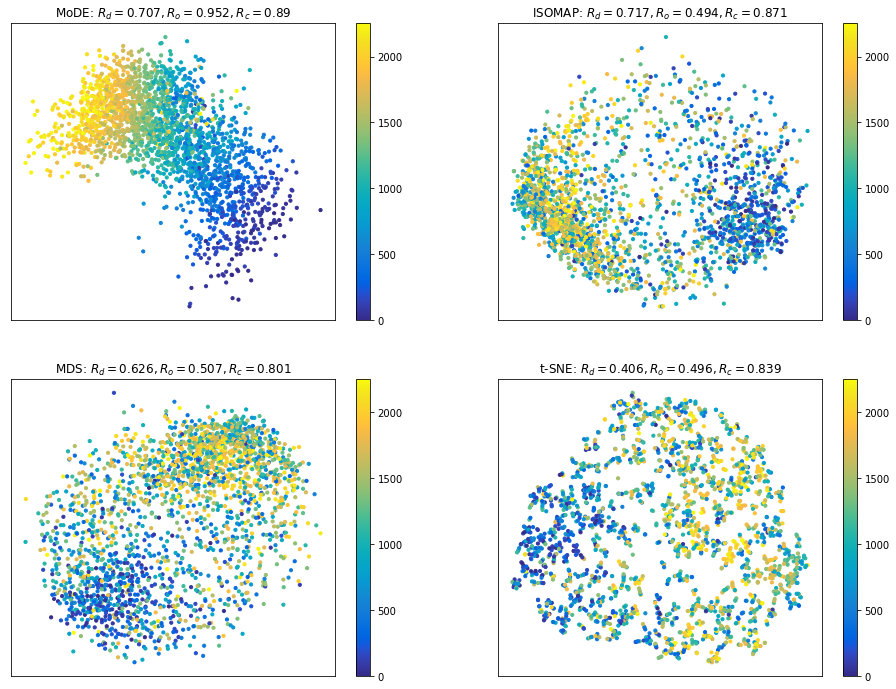

In [29]:
colors = np.argsort(np.argsort(score.squeeze()))
marker_size = 10
fig, ax = plt.subplots(2,2, figsize=(16,12))
p1 = ax[0,0].scatter(x_2d_mode[:, 0], x_2d_mode[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_mode, dm, n_neighbor=20)
R_c = correlation_metric(data, x_2d_mode, dm, n_neighbor=20)
R_o = order_preservation(x_2d_mode, dm, n_neighbor=20, score=score.squeeze())
ax[0,0].set_title("MoDE: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p1, ax=ax[0,0]);

p2 = ax[0,1].scatter(x_2d_isomap[:, 0], x_2d_isomap[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_isomap, dm, n_neighbor=20)
R_c = correlation_metric(data, x_2d_isomap, dm, n_neighbor=20)
R_o = order_preservation(x_2d_isomap, dm, n_neighbor=20, score=score.squeeze())
ax[0,1].set_title("ISOMAP: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p2, ax=ax[0,1]);

p3 = ax[1,0].scatter(x_2d_mds[:, 0], x_2d_mds[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_mds, dm, n_neighbor=20)
R_c = correlation_metric(data, x_2d_mds, dm, n_neighbor=20)
R_o = order_preservation(x_2d_mds, dm, n_neighbor=20, score=score.squeeze())
ax[1,0].set_title("MDS: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p3, ax=ax[1,0]);

p4 = ax[1,1].scatter(x_2d_tsne[:, 0], x_2d_tsne[:,1], c=colors, cmap=parula_map, s=marker_size)
R_d = distance_metric(data, x_2d_tsne, dm, n_neighbor=20)
R_c = correlation_metric(data, x_2d_tsne, dm, n_neighbor=20)
R_o = order_preservation(x_2d_tsne, dm, n_neighbor=20, score=score.squeeze())
ax[1,1].set_title("t-SNE: $R_d={}, R_o={}, R_c={}$".format(np.round(R_d, 3), np.round(R_o, 3), np.round(R_c, 3)))
fig.colorbar(p4, ax=ax[1,1]);
# remove the x and y ticks
for a in ax.reshape((-1)):
    a.set_xticks([])
    a.set_yticks([])
# plt.savefig("figures/ESG.jpg", dpi=1200);
plt.show();